<a href="https://colab.research.google.com/github/annieptba/data1030_project_-portugese-secondary-student-performance/blob/main/End_of_date_copy_of_V2_2040_cassava_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Create api key
#and yout colab:

#DO NOT NEED TO RUN UNLESS YOU HAVE TO CHANGE API
#from google.colab import files
#files.upload() #upload kaggle.json

In [ ]:
# Uninstall and reinstall kaggle
!pip uninstall -y kaggle
!pip install kaggle
# Set environment variables for using the Kaggle API.

# Go to Kaggle.
# Click on account.
# Click the 'Create New API Token' button.
# A .json file will download.
# Open the file with a text editor and
# copy and paste your username and key from that file below.


In [ ]:
import os

os.environ["KAGGLE_USERNAME"] = 'drewsolomon'
os.environ["KAGGLE_KEY"] = '394c2e9f24d40740b88dbd424a87235f'
# Download the data from the kaggle competition

raw_data_dir = "input/raw"

!kaggle competitions download -c cassava-leaf-disease-classification -p {raw_data_dir}
'done'

In [ ]:
# Check that the zip file was downloaded
!ls {raw_data_dir}

In [ ]:
# Fuze-zip allows us to access zipped folders without
# first unzipping them. This is helpful when working
# with large files.

!apt-get install -y fuse-zip
# Apply fuze-zip to the  data

input_dir = "/tmp/kaggle-data"
!mkdir {input_dir}
!fuse-zip input/raw/cassava-leaf-disease-classification.zip {input_dir}
# Check that everything is working.
!ls {input_dir}

In [ ]:
# Set up the environment
import math, re, os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from functools import partial
from sklearn.model_selection import train_test_split
import numpy as np 
import pandas as pd
import gc
import random
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
import cv2
from random import shuffle
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import keras
from keras.layers import Dense, Dropout, Input, MaxPooling2D, ZeroPadding2D, Conv2D, Flatten
from keras.models import Sequential, Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras import regularizers

from tensorflow.keras.layers import MaxPool2D, AveragePooling2D, GlobalAveragePooling2D
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from zipfile import ZipFile
import time
from datetime import timedelta
from io import BytesIO

# Image manipulation.
import PIL.Image

import pickle
import os

import random
print("Tensorflow version " + tf.__version__)

import seaborn as sns

In [ ]:
# Use this path to access the downloaded folders
base_path = '/tmp/kaggle-data/'

os.listdir(base_path)

In [ ]:
import pandas as pd
import json
train_data = pd.read_csv(base_path + '/train.csv')

In [ ]:
# show head of training data
train_data.head()

In [ ]:
# load the labels map json file
with open(base_path + 'label_num_to_disease_map.json', 'rb') as f:
    jsonlabels = json.load(f)
    
# add labels from json file into dictionary
labels_dict = {}
labels_dict[0] = jsonlabels['0']
labels_dict[1] = jsonlabels['1']
labels_dict[2] = jsonlabels['2']
labels_dict[3] = jsonlabels['3']
labels_dict[4] = jsonlabels['4']

# print labels dictionary
labels_dict

In [ ]:
# add class names to dataframe in new column
train_data["disease"] = train_data["label"].map(labels_dict)

In [ ]:
# print head
train_data.head()

In [ ]:
# get value counts by label
train_data['label'].value_counts()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# plot class balance
pd.value_counts(train_data['label']).plot.bar(color=['red', 'lightgreen', 'purple', 'pink', 'orange'])
plt.title('Cassava disease class balance', fontsize=16)
plt.xlabel('Class', fontsize=13)
plt.ylabel('Count', fontsize=13)
y_pos = np.arange(5)
plt.xticks(y_pos, rotation=0)
plt.savefig(base_path + 'cassava_disease_class_balance.jpg',bbox_inches='tight')
plt.show()

In [ ]:
pd.value_counts(train_data['label'], normalize=True).plot.bar(color=['red', 'lightgreen', 'purple', 'pink', 'orange'])
plt.title('Cassava disease class balance (normalized)', fontsize=16)
plt.xlabel('Class', fontsize=13)
plt.ylabel('Proportion', fontsize=13)
y_pos = np.arange(5)
plt.xticks(y_pos, rotation=0)
plt.savefig(base_path + 'cassava_disease_class_balance(normalized).jpg',bbox_inches='tight')
plt.show()

In [ ]:
#import seaborn as sns
plt.figure(figsize=(10, 6))
plt.title('Cassava Disease Class Balance', fontsize=16)
sns.countplot(y="disease", data=train_data, palette="pastel");

In [ ]:
# print class balances
pd.value_counts(train_data['disease'], normalize=True)

In [ ]:
sample_submission = pd.read_csv(base_path + 'sample_submission.csv')

In [ ]:
sample_submission.head()

In [ ]:
def plot_image_examples(class_label_num, n_rows=2, n_cols=2):
    """Plots a grid with example of images for the specified class."""
    # Gets the label of the class.
    class_label = labels_dict[class_label_num]
    
    # Filter the images by label.
    label_df = train_data[train_data.label == class_label_num]
    
    # Random indices to plot.
    rand_idx = np.random.randint(0, len(label_df), n_rows*n_cols)
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5,5))
    
    for row in range(n_rows):
        for col in range(n_cols):
            idx = rand_idx[row*n_cols + col]
            img_path = os.path.join(base_path + '/train_images', label_df.image_id.values[idx])
            img = PIL.Image.open(img_path)
            axs[row, col].imshow(img)
            axs[row, col].axis('off')
            axs[row, col].set_title(label_df.image_id.values[idx])
            
    plt.suptitle(class_label, fontsize=12, fontweight=550)
    plt.savefig(base_path + 'Example_of_images_for_each_class_(vertical).jpg',bbox_inches='tight')
    plt.show()

In [ ]:
for i in range(5):
  plot_image_examples(i,2,2) 

In [ ]:
_#random seed is used to replicate the same images in every run
np.random.seed(2020)
#plotting 5 random samples for each class with image name and disease name as title
for class_name in train_data['disease'].unique():
    plt.figure(figsize=(20,50))
    for idx,img_name in enumerate(np.random.choice(train_data[train_data['disease'] == class_name]['image_id'].values,
                                                   size=5,replace=False)):
        plt.subplot(1,5,idx+1)
        #reading the image and converting BGR color space to RGB
        img = cv2.cvtColor(cv2.imread(base_path+'train_images/'+img_name), cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
        # add title to center plot
        if idx ==2:
          plt.title(str(class_name), fontsize=20, pad=30)
          plt.subplots_adjust(hspace=1)

    plt.savefig(base_path + 'example_images_for_each_class.jpg',bbox_inches='tight')
    plt.show()

In [ ]:
for class_name in train_data['disease'].unique():
  print(class_name)

In [ ]:
# set hyperparameters
BATCH_SIZE = 64
STEPS_PER_EPOCH = len(train_data)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_data)*0.2 / BATCH_SIZE
EPOCHS = 16
TARGET_SIZE = 192

In [ ]:
train_data.label

In [ ]:
# convert labels to strings for sparse class mode
train_data.label = train_data.label.astype('str')

# separate and augment training images
train_generator = ImageDataGenerator(validation_split = 0.2,
                                     rotation_range = 20,
                                     preprocessing_function = None,
                                     zoom_range = 0.2,
                                     cval = 0.2,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     fill_mode = 'nearest',
                                     shear_range = 0.3,
                                     height_shift_range = 0.3,
                                     width_shift_range = 0.3) \
    .flow_from_dataframe(train_data,
                         directory = os.path.join(base_path, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

# separate and augment validation images
validation_generator = ImageDataGenerator(validation_split = 0.2) \
    .flow_from_dataframe(train_data,
                         directory = os.path.join(base_path, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")
'done'

In [ ]:
# print images in training set
print("images in training set: ", train_generator.n)

# printing images in validation set
print("images in validation set: ", validation_generator.n)

In [ ]:
# training set balance
pd.value_counts(train_generator.classes, normalize=True)

In [ ]:
# validation set balance
pd.value_counts(validation_generator.classes, normalize=True)

In [ ]:
from keras.applications.vgg16 import VGG16

# function to create model using transfer learning from VGG19 pre-trained model
def create_model():
    model = keras.Sequential()
    model.add(VGG16(include_top = False, weights = 'imagenet',
                             input_shape = (TARGET_SIZE, TARGET_SIZE, 3)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(5, activation = "softmax"))

    # compile model with Adam, sparse_categorical_crossentropy loss, and accuracy metric
    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# create baseline model
baseline_model = create_model()
baseline_model.summary()

In [ ]:
# fit model and track history
# tensorboard 
def tensorboard_callback(exp_name):
  return tf.keras.callbacks.TensorBoard(log_dir=base_path + exp_name, profile_batch=0, histogram_freq=1)

# fit
history = baseline_model.fit_generator(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    verbose = 1, 
    callbacks=[tensorboard_callback('vgg_baseline_history')]
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/16
267/267 [==============================] - 365s 1s/step - loss: 7.9841 - acc: 0.5849 - val_loss: 1.1620 - val_acc: 0.6165
Epoch 2/16
267/267 [==============================] - 338s 1s/step - loss: 1.1725 - acc: 0.6117 - val_loss: 1.1284 - val_acc: 0.6165
Epoch 3/16
267/267 [==============================] - 338s 1s/step - loss: 1.1440 - acc: 0.6114 - val_loss: 1.2000 - val_acc: 0.6172
Epoch 4/16
267/267 [==============================] - 336s 1s/step - loss: 1.0851 - acc: 0.6260 - val_loss: 1.0713 - val_acc: 0.6275
Epoch 5/16
267/267 [==============================] - 336s 1s/step - loss: 1.0287 - acc: 0.6344 - val_loss: 0.9830 - val_acc: 0.6459
Epoch 6/16
 73/267 [=======>......................] - ETA: 3:39 - loss: 0.9956 - acc: 0.6428

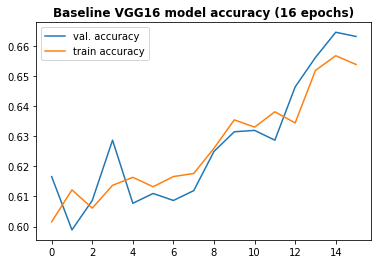

In [ ]:
# baseline model accuracy plot
plt.plot(history.history['val_acc'], label="val. accuracy")
plt.plot(history.history['acc'],  label="train accuracy")
plt.title('Baseline VGG16 model accuracy (16 epochs)', fontweight='bold')
plt.legend()
plt.savefig(base_path + 'Baseline VGG16 model accuracy.jpg',bbox_inches='tight')
plt.show()

In [ ]:
# function to save the Exponential Decay model just trained
def save_model(model):
  import os
  model_name = 'vgg_baseline_history.h5'
  save_dir = os.path.join(os.getcwd(), 'saved_models')
  
  # Save model and weights
  if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
  model_path = os.path.join(save_dir, model_name)
  model.save(model_path)
  print('Saved trained model at %s ' % model_path)

In [ ]:
# save the model
save_model(baseline_model)

Saved trained model at /content/saved_models/vgg_baseline_history.h5 


In [ ]:
from keras.models import load_model
new_model = load_model(base_path + 'vgg_baseline_history.h5')
new_model.load_weights(base_path + 'vgg_baseline_history.h5')
'done !'

In [ ]:
# save history as dataframe
baseline_history_df = pd.DataFrame(history.history)

# save training history
pickle.dump(history.history, open( 'vgg_baseline_history' + '.pickle', "wb"))

In [ ]:
# load baseline training data
baseline_history = open('vgg_baseline_history' + '.pickle', "rb")

In [ ]:
baseline_history_df

,loss,acc,val_loss,val_acc
0,3.226770,0.601586,1.187788,0.616605
1,1.188730,0.612200,1.185784,0.598881
2,1.192252,0.606135,1.160239,0.608675
3,1.175472,0.613716,1.113206,0.628731
4,1.133352,0.616371,1.110631,0.607743
5,1.126858,0.613249,1.083461,0.611007
6,1.104435,0.616632,1.109970,0.608675
7,1.089113,0.617654,1.070283,0.611940
8,1.052005,0.626049,0.987471,0.625000
9,1.009983,0.635494,0.986506,0.631530
